# Runtime

In [3]:
import math
import numpy as np

In [1]:
import barnes_hut
import bh.bh as bh
import fmm

In [9]:
num_particles = 10000
theta = 0.5
max_level = int(0.5 * math.log2(num_particles))
precision = 4

positions = np.random.random((num_particles,2))
masses = np.random.random(num_particles)

complex_positions = positions[:0] + 1j*positions[:1]

expansion_arrays = fmm.create_expansion_arrays(precision, max_level)

In [9]:
def bh_method(complex_positions, masses, theta, max_level):
    particles = [bh.Particle(charge, centre) for charge, centre in zip(masses, complex_positions)]
    n_crit = 2

    root = bh.RootCell(0.5+0.5j, 1, max_level, theta)

    root.populate_with_particles(particles, n_crit)
    root.populate_mass_CoM()
    root.calculate_particle_potentials()

def do_bh(particles, max_level):
    n_crit = 2
    root = bh.RootCell(0.5+0.5j, 1, max_level, 0.5)

    root.populate_with_particles(particles, n_crit)
    root.populate_mass_CoM()
    root.calculate_particle_potentials()

In [7]:
# storage lists

particle_numbers = np.logspace(1, 5, 20, dtype=int)
pairwise_times = []
fmm_times = []
bh_times =[]

precision = 5

In [10]:
for num in particle_numbers:
    particles = [fmm.Particle() for _ in range(num)]
    max_level = int(0.5 * math.log2(num))
    expansion_arrays = bh.create_expansion_arrays(precision, max_level)

    print(f'Num: {num}, Max_level: {max_level}')
    bh_time = %timeit -o fmm.do_fmm(precision, particles, expansion_arrays)
    fmm_times.append(fmm_time)
    bh_time = %timeit -o do_bh(particles, max_level)
    bh_times.append(bh_time)
    if bh_time.average > 10 or fmm_time.average > 10:
        break

Num: 10, Max_level: 1
347 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
112 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Num: 16, Max_level: 2
5.12 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
377 µs ± 6.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Num: 26, Max_level: 2
5.36 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
609 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Num: 42, Max_level: 2
5.9 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.08 ms ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Num: 69, Max_level: 3
39.8 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.96 ms ± 2.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Num: 112, Max_level: 3
41.4 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.66 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Num:

In [13]:
fmm_average = [time.average for time in fmm_times]
fmm_stdev = [time.stdev for time in fmm_times]
bh_average = [time.average for time in bh_times]
bh_stdev = [time.stdev for time in bh_times]

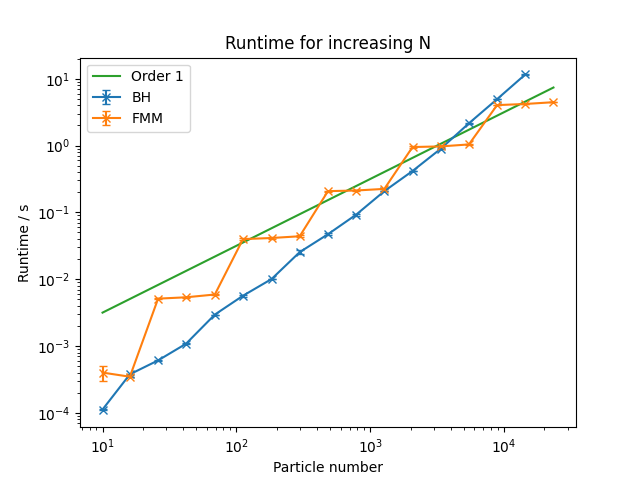

In [17]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, ax = plt.subplots()

ax.errorbar(particle_numbers[:len(bh_average)], bh_average, yerr=bh_stdev, fmt='x-', capsize=3, label='BH')
ax.errorbar(particle_numbers[:len(fmm_average)], fmm_average, yerr=fmm_stdev, fmt='x-', capsize=3, label='FMM')

ax.plot(particle_numbers[:len(fmm_average)], (particle_numbers[:len(fmm_average)]**1) * 10**-3.5, label='Order 1')
# ax.set_aspect('equal')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Particle number")
ax.set_ylabel("Runtime / s")
ax.set_title("Runtime for increasing N")
ax.legend()

plt.show()

# Errors

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import packages.general as general
import packages.fmm as fmm
import packages.bh as bh

In [3]:
num_particles = 1000
particles = [general.Particle() for _ in range(num_particles)]

max_level = int(math.log2(num_particles))

In [85]:
precisions = np.arange(2, 20, dtype=int)
fmm_pots = []

max_level = int(0.5 * math.log2(num_particles))
for precision in precisions:
    expansion_arrays = fmm.create_expansion_arrays(precision, max_level)
    fmm.do_fmm(precision, particles, expansion_arrays, zero_potentials=True)
    fmm_pots.append(np.array([particle.potential for particle in particles]))

In [86]:
thetas = np.linspace(0.01,0.8,40)
bh_pots = []

max_level = int(math.log2(num_particles))
for theta in thetas:
    bh.do_bh(particles, max_level, theta, zero_potentials=True)
    bh_pots.append(np.array([particle.potential for particle in particles]))

In [87]:
general.direct_particle_potentials(particles, zero_potentials=True)
dir_pot = np.array([particle.direct_potential for particle in particles])

In [88]:
fmm_fracs = []
bh_fracs = []

for pot in fmm_pots:
    difference = pot - dir_pot
    fmm_fracs.append(np.abs(difference / dir_pot))
for pot in bh_pots:
    difference = pot - dir_pot
    bh_fracs.append(np.abs(difference / dir_pot))

In [89]:
fmm_averages = [np.average(frac) for frac in fmm_fracs]
fmm_stdevs = [np.std(frac) for frac in fmm_fracs]
fmm_mins = [np.min(frac) for frac in fmm_fracs]
fmm_maxs = [np.max(frac) for frac in fmm_fracs]

bh_averages = [np.average(frac) for frac in bh_fracs]
bh_stdevs = [np.std(frac) for frac in bh_fracs]
bh_mins = [np.min(frac) for frac in bh_fracs]
bh_maxs = [np.max(frac) for frac in bh_fracs]

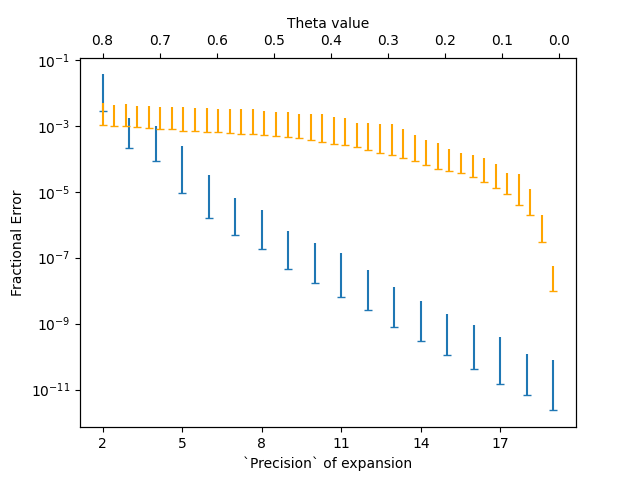

In [94]:
fig, ax1 = plt.subplots()

# ax1.set_title('Fractional Error for the collection of 10000 Particles as dependant on the `precision` value used', wrap=True)

ax2 = ax1.twiny()
ax2.invert_xaxis()

ax1.errorbar(precisions, fmm_averages, (fmm_mins, fmm_maxs), fmt='_', label='FMM')
ax2.errorbar(thetas, bh_averages, (bh_mins, bh_maxs), fmt='_', color='orange', label='BH')

ax1.set_yscale('log')

precision_ticks_spacing = (precisions[-1] - precisions[0]) / 5
precision_ticks_gaps = int(precision_ticks_spacing)
ax1.set_xticks(precisions[::precision_ticks_gaps])

ax1.set_xlabel('`Precision` of expansion')
ax2.set_xlabel('Theta value')
ax1.set_ylabel('Fractional Error')

# ax1.legend()
# ax2.legend()

plt.show()

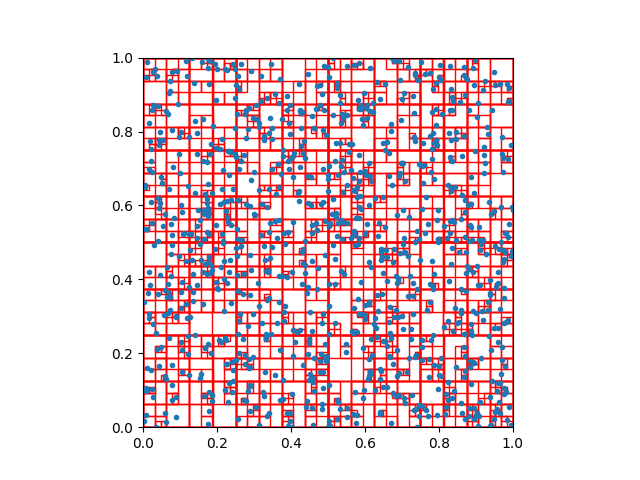

In [4]:
root = bh.RootCell(0.5+0.5j, 1, max_level, 0.5)
root.populate_with_particles(particles)

fig,ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

points = [source.centre for source in particles]
X,Y = np.real(points), np.imag(points)

ax.plot(X,Y, '.')

import matplotlib.patches as patches

def draw_rectangles(cell:bh.Cell):
    corner = cell.centre - cell.size*(0.5+0.5j)
    p = patches.Rectangle((corner.real,corner.imag),cell.size,cell.size, fill=False, color='red')
    ax.add_patch(p)
    if cell.bit_children == 0:
        return
    else:
        for child in cell.children:
            if child:
                draw_rectangles(child)

draw_rectangles(root)

plt.show()